In [1]:
from wrapper_functions import *
from ensemble import *

2022-11-09 13:26:32.195575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which is considered *experimental*."
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which i

TensorFlow version: 2.10.0. Expected: 2.7.0
TensorFlow Probability version: 0.18.0. Expected: 0.15.0


2022-11-09 13:26:56.877768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Experiment II: 2D Spatial Field

### Model Configs

In [2]:
# Optimization configs. 
# Consider reduce below parameters / set to `False` if MCMC is taking too long:
# mcmc_num_steps, mcmc_burnin, mcmc_nchain, mcmc_initialize_from_map.
map_step_size=5e-4   # @param
map_num_steps=10_000  # @param

mcmc_step_size=1e-4 # @param
mcmc_num_steps=1000 # @param

mcmc_nchain=10 # @param
mcmc_burnin=2_500 # @param
bne_mcmc_initialize_from_map="True" # @param ["False", "True"]

bne_mcmc_initialize_from_map = eval(bne_mcmc_initialize_from_map)


In [3]:
# BMA parameters.
y_noise_std = 0.01  # Note: Changed from 0.1 # @param
bma_gp_lengthscale = .07 # @param
bma_gp_l2_regularizer = 0.15 # @param

bma_n_samples_train = 100 # @param
bma_n_samples_eval = 250 # @param
bma_n_samples_test = 250 # @param
bma_seed = 0 # @param


In [6]:
# BNE parameters.
bne_gp_lengthscale = .1 # 5. # @param
bne_gp_l2_regularizer = .05 # 15 # @param
bne_variance_prior_mean = -2.5 # @param
bne_skewness_prior_mean = -2.5 # @param
bne_seed = 0 # @param

### Read training/prediction data

In [2]:
training_eastMA = pd.read_csv('../data/training_dataset/training_eastMA.csv')
training_eastMA_noMI = training_eastMA[:51]
training_eastMA_folds = pd.read_csv('../data/training_dataset/training_eastMA_folds.csv')
base_model_predictions_eastMA = pd.read_csv('../data/prediction_dataset/base_model_predictions_eastMA.csv')
display(training_eastMA.shape, training_eastMA_folds.shape, base_model_predictions_eastMA.shape)
print("pred longitude max and min", base_model_predictions_eastMA["lon"].max(),base_model_predictions_eastMA["lon"].min())
print("pred latitude max and min", base_model_predictions_eastMA["lat"].max(),base_model_predictions_eastMA["lat"].min())
#list(base_model_predictions_eastMA.columns)
print("train longitude max and min", training_eastMA["lon"].max(),training_eastMA["lon"].min())
print("train latitude max and min", training_eastMA["lat"].max(),training_eastMA["lat"].min())


training51= pd.read_csv('../data/training_dataset/training51.csv')

(55, 7)

(55, 10)

(84421, 5)

pred longitude max and min -69.93 -73.5
pred latitude max and min 44.3 40.6
train longitude max and min -70.023598 -73.443056
train latitude max and min 44.107524 40.74529


In [3]:
# standardize
X_train1 = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)
X_test1 = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)
X_valid = np.concatenate((X_train1, X_test1), axis=0)
X_centr = np.mean(X_valid, axis=0)
X_scale = np.max(X_valid, axis=0) - np.min(X_valid, axis=0)

X_train1 = (X_train1 - X_centr) / X_scale
X_test1 = (X_test1 - X_centr) / X_scale

Y_train = np.expand_dims(training_eastMA_noMI["aqs"], 1).astype(np.float32)
#Y_test = np.expand_dims(base_model_predictions_eastMA["pred_av"], 1).astype(np.float32)

print("2011 center and scale: ", X_centr, X_scale)

2011 center and scale:  [-72.185104  42.680347] [3.5699997 3.7000008]


In [4]:
base_model_names = ["pred_av", "pred_gs", "pred_caces"]
base_preds_train = tf.stack([training_eastMA_noMI[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
base_preds_test = tf.stack([base_model_predictions_eastMA[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
#base_preds_test
display(base_preds_train.shape, base_preds_test.shape)

TensorShape([51, 3])

TensorShape([84421, 3])

In [20]:
import rpy2
#from rpy2.robjects import pandas2ri
from rpy2 import robjects as ro
from rpy2.robjects.packages import importr
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, r
from rpy2.robjects.conversion import localconverter
# import R's "base" package
base = importr('base')
#ms = importr('MSGARCH')
# import R's "utils" package
utils = importr('utils')

with localconverter(ro.default_converter + pandas2ri.converter):
  r_from_pd_df = ro.conversion.py2rpy(training_eastMA_noMI)

r_from_pd_df

mgcv  = importr('mgcv')
stats = importr('stats')
ref_model = LinearRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=0)

rmse_lr = []
rmse_bma = []
rmse_gam = []

for train_index, test_index in kf.split(X_train1):
      #print("Train:", train_index, "Validation:",test_index)
      X_tr, X_te = X_train1[train_index], X_train1[test_index] 
      Y_tr, Y_te = Y_train[train_index], Y_train[test_index]

      base_preds_tr, base_preds_te = base_preds_train.numpy()[train_index], base_preds_train.numpy()[test_index]
      
      # Ref: linear regression
      ref_model.fit(X_tr, Y_tr)
      Y_pred = ref_model.predict(X_te)
      rmse_lr.append(rmse(Y_te, Y_pred))

      r_dat_py = training_eastMA_noMI
      r_dat_py[['lon', 'lat']] = X_train1
      
      with localconverter(ro.default_converter + pandas2ri.converter):
            r_tr = ro.conversion.py2rpy(r_dat_py.iloc[train_index])
            r_te = ro.conversion.py2rpy(r_dat_py.iloc[test_index])

      # Ref: GAM
      #df = training_eastMA_noMI.iloc[train_index]
      gam_model = mgcv.gam(ro.Formula('aqs ~ s(lon, lat, by=pred_av, k=4) + s(lon, lat,by=pred_gs, k=4) +s(lon, lat, by=pred_caces, k=4)'), data=r_tr)
      a=stats.predict(gam_model, newdata =r_te)
      print(a)
      rmse_gam.append(rmse(Y_te, np.asanyarray(a).reshape(-1,1)))
      #print(rmse_gam)

print(rmse_lr, rmse_gam)
print("RMSE LR: ", np.mean(rmse_lr), np.std(rmse_lr))
print("RMSE GAM: ", np.mean(rmse_gam), np.std(rmse_gam))




/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


        2        10        11        22        28        29 
10.211692  9.819233  5.673589  9.639125  5.343900  9.012283 



/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


        4        26        32        33        45 
 9.746925  8.858188  9.322724 10.035579  7.173532 



/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


       7       27       34       35       41 
5.753455 8.372504 9.240131 8.482528 5.604121 



/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


      14       18       42       46       48 
9.626291 8.633853 5.783775 7.117513 6.564034 

      15       16       30       31       43 
8.608835 8.608332 8.629879 8.368166 7.697025 



/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


       8       13       20       25       50 
9.300969 9.357386 5.450329 7.711960 7.988648 

        1         5        17        37        40 
10.588809  9.398915  6.534695  8.884988  4.260287 



/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


       6       12       23       24       38 
9.605954 8.443477 9.640203 9.419740 8.772681 

       9       19       21       36       39 
8.212285 8.921156 8.135322 8.099314 7.519223 



/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


       0        3       44       47       49 
9.294020 9.288111 3.922368 5.270174 9.625108 

[1.6682197, 0.8446648, 2.0171714, 0.9632994, 1.7046735, 1.3922702, 2.009299, 0.8785388, 0.85990846, 3.6984842] [0.4076122911410147, 0.620054865920744, 1.074823763530061, 1.0825851802176598, 1.053331252914463, 0.6232383511079379, 1.171068512762113, 0.9669676644344501, 0.6377131437768805, 1.2830493171899717]
RMSE LR:  1.603653 0.82752544
RMSE GAM:  0.8920444342995296 0.2788681022382428


In [27]:
print(base.summary(gam_model))



Family: gaussian 
Link function: identity 

Formula:
aqs ~ s(lon, lat, by = pred_av, k = 4) + s(lon, lat, by = pred_gs, 
    k = 4) + s(lon, lat, by = pred_caces, k = 4)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   0.1594     1.3619   0.117    0.908

Approximate significance of smooth terms:
                      edf Ref.df     F p-value   
s(lon,lat):pred_av      3      3 3.472 0.02589 * 
s(lon,lat):pred_gs      3      3 1.115 0.35593   
s(lon,lat):pred_caces   3      3 5.712 0.00264 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.748   Deviance explained = 79.9%
GCV = 0.72953  Scale est. = 0.57094   n = 46



In [35]:
ref_model = LinearRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=5)

rmse_lr = []
rmse_bma = []
rmse_gam = []

for train_index, test_index in kf.split(X_train1):
      #print("Train:", train_index, "Validation:",test_index)
      X_tr, X_te = X_train1[train_index], X_train1[test_index] 
      Y_tr, Y_te = Y_train[train_index], Y_train[test_index]

      base_preds_tr, base_preds_te = base_preds_train.numpy()[train_index], base_preds_train.numpy()[test_index]
      
      # Ref: linear regression
      ref_model.fit(X_tr, Y_tr)
      Y_pred = ref_model.predict(X_te)
      rmse_lr.append(rmse(Y_te, Y_pred))

      # Ref: GAM
      #df = training_eastMA_noMI.iloc[train_index]
      
      gam_model = GAMEnsemble()
      gam_model.train(X_tr, Y_tr, base_preds_tr)
      y_gam_pred, y_gam_pred_se = (
            gam_model.predict(X_te, base_preds_te))
      #rmse_gam.append(rmse(Y_te, gam_pred))
      #print(rmse_gam)

In [92]:
Y_te -Y_pred

array([[ 0.16446114],
       [ 0.4400692 ],
       [-0.15744448],
       [-0.0414896 ],
       [-3.911059  ]], dtype=float32)

In [63]:
class GAMEnsemble(EnsembleModel):
    """Implements GAM ensemble in [1]."""

    def __init__(self, nonlinear_ensemble=False, residual_process=True):
        """
        Initializer.

        Args:
            nonlinear_ensemble: (bool) Whether use nonlinear term to transform base model.
            residual_process: (bool) Whether model residual process.
        """
        model_name = (
            "Generalized Additive Ensemble" if residual_process
            else "{} Stacking".format("Nonlinear" if nonlinear_ensemble else "Linear"))

        super().__init__(model_name)
        self.gam_model = None
        self.nonlinear_ensemble = nonlinear_ensemble
        self.model_residual = residual_process

    def train(self, X, y, base_pred):
        """Trains ensemble model based on data and base predictions.

        Adds value to class attribute "model_weight"

        Args:
            X: (np.ndarray) Training features, shape (N, D)
            y: (np.ndarray)  Training labels, shape (N, 1)
            base_pred: (dict of np.ndarray) Dictionary of base model predictions
                With keys (str) being model name, and values (np.ndarray) being
                predictions corresponds to X and y.
        """
        # build feature and  gam terms
        ens_feature, feature_terms = self._build_ensemble_feature(X, base_pred)

        # define model
        self.gam_model = LinearGAM(feature_terms)

        # additional fine-tuning
        lam_grid = self._build_lambda_grid(n_grid=100)
        self.gam_model.gridsearch(X=ens_feature, y=y, lam=lam_grid,
                                  progress=False)

    def predict(self, X, base_pred):
        """Predicts label based on feature and base model.

        Args:
            X: (np.ndarray) Training features, shape (N, D)
            base_pred: (dict of np.ndarray) Dictionary of base model predictions
                With keys (str) being model name, and values (np.ndarray) being
                predictions corresponds to X and y.

        Returns:
            (np.ndarray) ensemble prediction and variance

        Raises:
            (ValueError) If self.model_weight is empty.
        """
        if not self.gam_model:
            raise ValueError("Attribute gam_model empty."
                             "Model was not trained properly.")

        # build feature and  gam terms
        ens_feature, _ = self._build_ensemble_feature(X, base_pred)

        # prediction
        prediction = self.gam_model.predict(ens_feature)
        prediction_var = ((self.gam_model.prediction_intervals(
            ens_feature, width=.95)[:, 1] - prediction) / 2) ** 2

        return prediction, prediction_var

    def _build_ensemble_feature(self, X, base_pred):
        """Builds featurre array and corresponding GAM TermList.

        Terms corresponding to X will be summation of
            dimension-wise splines, plus a tensor-product term across all dimension.

        """
        ensemble_term_func = s if self.nonlinear_ensemble else l

        ens_feature = np.asarray(list(base_pred.values())).T
        term_list = [ensemble_term_func(dim_index) for dim_index in range(ens_feature.shape[1])]

        # optionally, add residual process
        if self.model_residual:
            # build gam terms
            term_list += [s(dim_index) for dim_index in
                          range(ens_feature.shape[1],
                                ens_feature.shape[1] + X.shape[1])]
            if X.shape[1] > 1:
                term_list += [te(*list(ens_feature.shape[1] +
                                       np.array(range(X.shape[1]))))]

            # update features
            ens_feature = np.concatenate([ens_feature, X], axis=1)

        gam_feature_terms = TermList(*term_list)

        return ens_feature, gam_feature_terms

    def _build_lambda_grid(self, n_grid=100):
        # count actual number of terms in each nonlinear term
        # (e.g. te(0, 1) will actually have two terms)
        n_terms = np.sum([len(model_term._terms) if model_term.istensor else 1
                          for model_term in self.gam_model.terms])
        lam = np.random.rand(n_grid, n_terms)
        # rescale to between (0, 1)
        lam_norm = (lam - np.min(lam)) / (np.max(lam) - np.min(lam))

        return np.exp((lam_norm - 0.5) * 6)


## Bayesian Model Averaging

A Bayesian ensemble model where ensemble weights $w_k's$ are parameterized by Gaussian process priors:

$y \sim N(\mu(x), \sigma^2)$ 

$\mu(x) = \sum_{k=1}^K w_k(x) * m_k(x) \quad$  where $\{m_k\}_{k=1}^K$ are base model predictions.

$w(x) = softmax(f(x)) \qquad\;\;\;$ where $w=[w_1, \dots, w_K]$ and $f=[f_1, \dots, f_K]$

$f \stackrel{i.i.d.}{\sim} GaussianProcess(0, k)$




In [315]:
# Assemble into configs.
bma_model_config = DEFAULT_GP_CONFIG.copy()
map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()

bma_model_config.update(dict(lengthscale=bma_gp_lengthscale,
                             l2_regularizer=bma_gp_l2_regularizer,
                             y_noise_std=y_noise_std,
                             activation=None))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))

mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps,
                       burnin=mcmc_burnin,
                       nchain=mcmc_nchain,
                       debug_mode=False))

### Check 10-fold Random Cross Validation RMSE

In [301]:
# find the index of max and min  for lon and lat
min_index_lon = training_eastMA_noMI[['lon']].idxmin().values.tolist()
max_index_lon = training_eastMA_noMI[['lon']].idxmax().values.tolist()
min_index_lat = training_eastMA_noMI[['lat']].idxmin().values.tolist()
max_index_lat = training_eastMA_noMI[['lat']].idxmax().values.tolist()
# concetenate the index
edge_list = min_index_lon + max_index_lon + min_index_lat + max_index_lat
# exclude edge_list index from X_train1
train_wo_edge = X_train1[~np.isin(np.arange(len(X_train1)), edge_list)]
# exclude edge_list index from Y_train
Y_wo_edge = Y_train[~np.isin(np.arange(len(Y_train)), edge_list)]
# edge_list index from X_train1
edge_list_X = X_train1[np.isin(np.arange(len(X_train1)), edge_list)]
# edge_list index from Y_train
edge_list_Y = Y_train[np.isin(np.arange(len(Y_train)), edge_list)]
edge_list_base = base_preds_train[np.isin(np.arange(len(base_preds_train)), edge_list)]


<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[ 9.2      , 10.377717 ,  9.456476 ],
       [ 9.8      , 11.016994 ,  9.316178 ],
       [ 4.6      ,  8.377447 ,  6.027947 ],
       [ 8.6      ,  8.057583 ,  7.3990026]], dtype=float32)>

In [18]:
ref_model = LinearRegression()
kf = KFold(n_splits=10) 

rmse_lr = []
rmse_bma = []
rmse_gam = []

for train_index, test_index in kf.split(X_train1):
      #print("Train:", train_index, "Validation:",test_index)
      X_tr, X_te = X_train1[train_index], X_train1[test_index] 
      Y_tr, Y_te = Y_train[train_index], Y_train[test_index]
      
      # Ref: linear regression
      ref_model.fit(X_tr, Y_tr)
      Y_pred = ref_model.predict(X_te)
      rmse_lr.append(rmse(Y_te, Y_pred))
      print(rmse_lr)


      base_preds_tr, base_preds_te = base_preds_train.numpy()[train_index], base_preds_train.numpy()[test_index]
      print(X_tr.shape, X_te.shape, Y_tr.shape, Y_te.shape, base_preds_tr.shape, base_preds_te.shape)

      # build model & run MCMC
      bma_prior, bma_gp_config = bma_dist(X_tr, 
                                    base_preds_tr, 
                                    **bma_model_config)

      bma_model_config.update(bma_gp_config)


      bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior, 
                                           model_config=bma_model_config,
                                           Y=Y_tr, 
                                           map_config=map_config,
                                           mcmc_config=mcmc_config)


      bma_joint_samples = make_bma_samples(X_te, None, base_preds_te, 
                                     bma_weight_samples=bma_gp_w_samples[0],
                                     bma_model_config=bma_model_config,
                                     n_samples=bma_n_samples_eval, 
                                     seed=bne_seed,
                                     y_samples_only=False)
      y_pred = bma_joint_samples['y']
      y_pred = tf.reduce_mean(y_pred, axis=0)

      rmse_bma.append(rmse(Y_te, y_pred))
      print(rmse_bma)

print("RMSE LR: ", np.mean(rmse_lr), np.std(rmse_lr))
print("RMSE BMA: ", np.mean(rmse_bma), np.std(rmse_bma))


[0.8130488]


NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'pandas.core.frame.DataFrame'>'

### Check 10-fold Spatial Cross Validation RMSE

In [11]:
# fold_id=10
# X_te = X_train1[training51.index[training51["fold"] == fold_id]]
# X_tr = X_train1[training51.index[training51["fold"] != fold_id]]
# Y_te = Y_train[training51.index[training51["fold"] == fold_id]]
# Y_tr = Y_train[training51.index[training51["fold"] != fold_id]]

# base_preds_tr=base_preds_train.numpy()[training51.index[training51["fold"] != fold_id]]
# base_preds_te=base_preds_train.numpy()[training51.index[training51["fold"] == fold_id]]

# # build model & run MCMC
# bma_prior, bma_gp_config = bma_dist(X_tr, 
#                                     base_preds_tr, 
#                                     **bma_model_config)

# bma_model_config.update(bma_gp_config)


# bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior, 
#                                            model_config=bma_model_config,
#                                            Y=Y_tr, 
#                                            map_config=map_config,
#                                            mcmc_config=mcmc_config)


# bma_joint_samples = make_bma_samples(X_te, None, base_preds_te, 
#                                      bma_weight_samples=bma_gp_w_samples[0],
#                                      bma_model_config=bma_model_config,
#                                      n_samples=bma_n_samples_eval, 
#                                      seed=bne_seed,
#                                      y_samples_only=False)
# y_pred = bma_joint_samples['y']
# y_pred = tf.reduce_mean(y_pred, axis=0)

# print(rmse(Y_te, y_pred))

# # Construct data from BMA samples, shapes (num_samples * num_data, ...)
# means_tr_mcmc, X_tr_mcmc, Y_tr_mcmc = make_bma_samples(
#     X_tr, Y_tr, base_preds_tr, 
#     bma_weight_samples=bma_gp_w_samples[0],
#     bma_model_config=bma_model_config,
#     n_samples=bma_n_samples_train,
#     seed=bma_seed, 
#     prepare_mcmc_training=True)

# # Mean samples based on test data, shape (num_samples, num_data, num_output).
# # It is used to generate final examples in `make_bne_samples()`.
# means_te_mcmc = make_bma_samples(
#     X_te, None, base_preds_te, 
#     bma_weight_samples=bma_gp_w_samples[0],
#     bma_model_config=bma_model_config,
#     n_samples=bma_n_samples_test,
#     seed=bma_seed)

In [12]:

# rmse_bma = []
# rmse_bne = []

# for fold_id in range(1, 11):
#     # prepare cross-validation data
#     X_te = X_train1[training51.index[training51["fold"] == fold_id]]
#     X_tr = X_train1[training51.index[training51["fold"] != fold_id]]
#     Y_te = Y_train[training51.index[training51["fold"] == fold_id]]
#     Y_tr = Y_train[training51.index[training51["fold"] != fold_id]]

#     base_preds_tr=base_preds_train.numpy()[training51.index[training51["fold"] != fold_id]]
#     base_preds_te=base_preds_train.numpy()[training51.index[training51["fold"] == fold_id]]

#     # build model & run MCMC
#     bma_prior, bma_gp_config = bma_dist(X_tr, 
#                                     base_preds_tr, 
#                                     **bma_model_config)

#     bma_model_config.update(bma_gp_config)

#     print("BMA model config: ", bma_model_config, "mcmc_config: ", mcmc_config, "map_config: ", map_config)
#     bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior, 
#                                            model_config=bma_model_config,
#                                            Y=Y_tr, 
#                                            map_config=map_config,
#                                            mcmc_config=mcmc_config)


#     bma_joint_samples = make_bma_samples(X_te, None, base_preds_te, 
#                                      bma_weight_samples=bma_gp_w_samples[0],
#                                      bma_model_config=bma_model_config,
#                                      n_samples=bma_n_samples_eval, 
#                                      seed=bne_seed,
#                                      y_samples_only=False)

#     y_pred = bma_joint_samples['y']
#     y_pred = tf.reduce_mean(y_pred, axis=0)
#     rmse_bma.append(rmse(Y_te, y_pred))
#     print(rmse_bma)

#     # Construct data from BMA samples, shapes (num_samples * num_data, ...)
#     means_tr_mcmc, X_tr_mcmc, Y_tr_mcmc = make_bma_samples(
#         X_tr, Y_tr, base_preds_tr, 
#         bma_weight_samples=bma_gp_w_samples[0],
#         bma_model_config=bma_model_config,
#         n_samples=bma_n_samples_train,
#         seed=bma_seed, 
#         prepare_mcmc_training=True)

#     # Mean samples based on test data, shape (num_samples, num_data, num_output).
#     # It is used to generate final examples in `make_bne_samples()`.
#     means_te_mcmc = make_bma_samples(
#         X_te, None, base_preds_te, 
#         bma_weight_samples=bma_gp_w_samples[0],
#         bma_model_config=bma_model_config,
#         n_samples=bma_n_samples_test,
#         seed=bma_seed)

#     # # # BNE GP Configs.
# # # lengthscale = 1. # @param
# # # l2_regularizer = 10. # @param

# # BNE model configs. 
# # If estimate_mean=False, only estimates a constant variance on top of the 
# # original model.
#     estimate_mean = "True" # @param ["True", "False"]
#     variance_prior_mean=0. # @param
# # # MAP and MCMC configs
# # map_step_size=0.1 # @param
# # map_num_steps=10_000 # @param

# # mcmc_step_size=1e-2 # @param
# # mcmc_num_steps=10_000 # @param

#     bne_gp_config = DEFAULT_GP_CONFIG.copy()
#     bne_model_config = DEFAULT_BNE_CONFIG.copy()

#     map_config = DEFAULT_MAP_CONFIG.copy()
#     mcmc_config = DEFAULT_MCMC_CONFIG.copy()


#     bne_gp_config.update(dict(lengthscale=bne_gp_lengthscale, 
#                           l2_regularizer=bne_gp_l2_regularizer))
#     bne_model_config.update(dict(estimate_mean=eval(estimate_mean),
#                              variance_prior_mean=variance_prior_mean,
#                              **bne_gp_config))

#     map_config.update(dict(learning_rate=map_step_size,
#                        num_steps=map_num_steps))
#     mcmc_config.update(dict(step_size=mcmc_step_size, 
#                         num_steps=mcmc_num_steps,
#                        burnin=mcmc_burnin,
#                        nchain=mcmc_nchain))
    
#     # build model & run MCMC
#     bne_prior, bne_gp_config = bne_model_dist(
#             inputs=X_tr_mcmc,
#             mean_preds=means_tr_mcmc,
#             **bne_model_config)

#     bne_model_config.update(bne_gp_config)

#     print("BNE model config: ", bne_model_config, "mcmc_config: ", mcmc_config, "map_config: ", map_config)
#     # Estimates GP weight posterior using MCMC.
#     bne_gp_w_samples = run_posterior_inference(model_dist=bne_prior,
#                                             model_config=bne_gp_config,
#                                             Y=Y_tr_mcmc,
#                                             map_config=map_config,
#                                             mcmc_config=mcmc_config,
#                                             initialize_from_map=True)
#     # Generates the posterior sample for all model parameters. 
#     bne_joint_samples = make_bne_samples(X_te,
#                                         mean_preds=means_te_mcmc,
#                                         bne_model_config=bne_model_config,
#                                         bne_weight_samples=bne_gp_w_samples[0],
#                                         seed=bne_seed)
    
#     y_pred = bne_joint_samples['y']
#     means_pred = np.mean(y_pred, axis=0)
#     rmse_bne.append(rmse(Y_te, y_pred))
#     print(rmse_bne)

    
# print(rmse_bma, rmse_bne)


### Build model

In [13]:
bma_prior, bma_gp_config = bma_dist(X_train1, 
                                    base_preds_train, 
                                    **bma_model_config)

bma_model_config.update(bma_gp_config)

# Check if the model graph is specified correctly.
bma_prior.resolve_graph()

(('gp_weights', ()), ('y', ('gp_weights',)))

In [14]:
display(bma_model_config)

{'lengthscale': 0.07,
 'l2_regularizer': 0.15,
 'hidden_units': 1024,
 'y_noise_std': 0.01,
 'activation': None,
 'units': 3,
 'seed': 0}

### Run MCMC

In [15]:
# bma_gp_w_samples, chain_samples, sampler_stat = run_posterior_inference(model_dist=bma_prior, 
#                                            model_config=bma_model_config,
#                                            Y=Y_train, 
#                                            map_config=map_config,
#                                            mcmc_config=mcmc_config)

# Above the debug mode

bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior, 
                                           model_config=bma_model_config,
                                           Y=Y_train, 
                                           map_config=map_config,
                                           mcmc_config=mcmc_config)


bma_joint_samples = make_bma_samples(X_test1, None, base_preds_test, 
                                     bma_weight_samples=bma_gp_w_samples[0],
                                     bma_model_config=bma_model_config,
                                     n_samples=bma_n_samples_eval, 
                                     seed=bne_seed,
                                     y_samples_only=False)



Running MAP:	409032.25...157770.984375...141512.0625...131225.21875...126107.3125...123341.8359375...121954.1328125...121116.6796875...120512.6015625...120008.921875...Done.
Running MCMC:	Acceptance Ratio: 0.6501743197441101


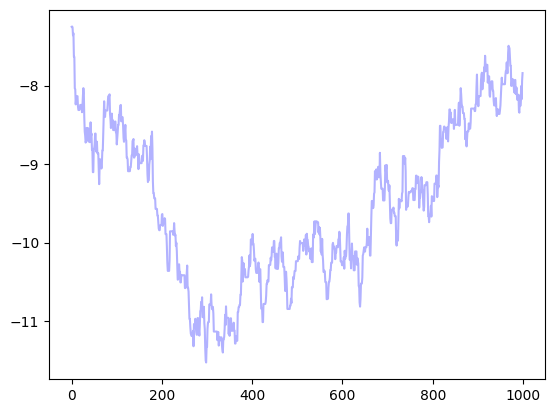

In [18]:
# plt.plot(chain_samples[:, 9, 31, 1], c='b', alpha=.3)
# # plt.title('Traceplot')
# # plt.plot(bma_gp_w_samples[1][:,9, 127, 1].numpy(), 'b')
# # plt.xlabel('Iteration')
# # plt.ylabel('Position')
# plt.show()

### Prepare Data for BAE/BNE

In [16]:
# Construct data from BMA samples, shapes (num_samples * num_data, ...)
means_train_mcmc, X_train_mcmc, Y_train_mcmc = make_bma_samples(
    X_train1, Y_train, base_preds_train, 
    bma_weight_samples=bma_gp_w_samples[0],
    bma_model_config=bma_model_config,
    n_samples=bma_n_samples_train,
    seed=bma_seed, 
    prepare_mcmc_training=True)

# Mean samples based on test data, shape (num_samples, num_data, num_output).
# It is used to generate final examples in `make_bne_samples()`.
means_test_mcmc = make_bma_samples(
    X_test1, None, base_preds_test, 
    bma_weight_samples=bma_gp_w_samples[0],
    bma_model_config=bma_model_config,
    n_samples=bma_n_samples_test,
    seed=bma_seed)

## Bayesian Additive Ensemble

Given $\mu(x)$ the posterior of a Bayesian ensemble model, the Bayesian Additive Ensemble is defined as:    

$y \sim N(\mu(x) + r(x), \sigma^2)$

$r \sim GaussianProcess(0, k)$

The additive ensemble $r(x)$ services two purposes: 

1. Mitigates systematic bias in model prediction; 
2. Quantifies the model's epistemic uncertainty.

In [83]:
# # # BNE GP Configs.
# # lengthscale = 1. # @param
# # l2_regularizer = 10. # @param

# BNE model configs. 
# If estimate_mean=False, only estimates a constant variance on top of the 
# original model.
estimate_mean = "True" # @param ["True", "False"]
variance_prior_mean=0. # @param
# # MAP and MCMC configs
# map_step_size=0.1 # @param
# map_num_steps=10_000 # @param

# mcmc_step_size=1e-2 # @param
# mcmc_num_steps=10_000 # @param

bne_gp_config = DEFAULT_GP_CONFIG.copy()
bne_model_config = DEFAULT_BNE_CONFIG.copy()

map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()


bne_gp_config.update(dict(lengthscale=bne_gp_lengthscale, 
                          l2_regularizer=bne_gp_l2_regularizer))
bne_model_config.update(dict(estimate_mean=eval(estimate_mean),
                             variance_prior_mean=variance_prior_mean,
                             **bne_gp_config))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))
mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps,
                       burnin=mcmc_burnin,
                       nchain=mcmc_nchain,
                       debug_mode=False))

### Build Model

In [85]:
# Construct posterior sampler.
bne_prior, bne_gp_config = bne_model_dist(
    inputs=X_train_mcmc,
    mean_preds=means_train_mcmc,
    **bne_model_config)

bne_model_config.update(bne_gp_config)
print(f'prior model graph: {bne_prior.resolve_graph()}')

prior model graph: (('gp_weights', ()), ('y', ('gp_weights',)))


### Run MCMC

In [86]:
# Estimates GP weight posterior using MCMC.
bne_gp_w_samples = run_posterior_inference(model_dist=bne_prior,
                                           model_config=bne_gp_config,
                                           Y=Y_train_mcmc,
                                           map_config=map_config,
                                           mcmc_config=mcmc_config,
                                           initialize_from_map=True)
# Generates the posterior sample for all model parameters. 
bne_joint_samples = make_bne_samples(X_test1,
                                     mean_preds=means_test_mcmc,
                                     bne_model_config=bne_model_config,
                                     bne_weight_samples=bne_gp_w_samples[0],
                                     seed=bne_seed)

Running MAP:	18988.62890625...15931.923828125...15861.28515625...15824.08984375...15795.41015625...15773.033203125...15754.7421875...15737.87890625...15720.84375...15703.337890625...Done.
Running MCMC:	Acceptance Ratio: 0.8144306540489197


In [87]:
surface_pred_bae = {k: np.mean(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}
surface_var_bae = {k: np.var(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}

# # dealing with NA

## Bayesian Nonparametric Ensemble (Variance Only)
So far, we are only estimating the mean-component of the model, i.e., we are assuming: 

$y \sim Gaussian(m(x), \sigma^2); \quad m(x) = GP(0, k)$.

By doing so, the model is implicitly assuming the distribution of $y$ is always a symmetric Gaussian distribution with constant mean across space and time. As a result, our model can only quantify model uncertainty (due to lack of data) via the GP prior, but cannot flexibly capture the data uncertainty that is inherent to the empirical distribution of y.

To resolve this, we extend the ensemble's outcome distribution $y | f$ by also estimating the higher moments of the data distribution (e.g., variance, skewness, etc) using flexible estimators. Specifically, we specify the outcome distribution family to the [maximum-entropy distribution](https://en.wikipedia.org/wiki/Principle_of_maximum_entropy) given the known moments, so the predictive distribution is [minimax](https://arxiv.org/pdf/math/0410076.pdf) and still statistically efficient to estimate.

For example, when we want to estimate the first two moments (mean and variance) of the distribution, this leads to a Gaussian distribution with spatio-temporally adaptive variance $\sigma(x)^2$:

$$y \sim Gaussian(m(x), \sigma(x)^2); \quad \mbox{where} \quad m \sim GP(0, k_m), \sigma \sim GP(0, k_\sigma)$$

and when we want to estimate the first three moments (mean and variance) of the distribution, this leads to a [Exponentially-modifed Gaussian](https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution) (EMG) distribution with spatio-temporally adaptive variance $\sigma(x)^2$ and skewness $\lambda(x)$:

$$y \sim EMG(m(x), \sigma(x)^2, \lambda(x)); \quad \mbox{where} \quad m \sim GP(0, k_m), \sigma \sim GP(0, k_\sigma), \lambda \sim GP(0, k_\lambda)$$




### Define Model & Run MCMC

In [88]:
# Construct posterior sampler.
bne_prior, bne_gp_config = bne_model_dist(
    inputs=X_train_mcmc,
    mean_preds=means_train_mcmc,
    **bne_model_config)

bne_model_config.update(bne_gp_config)
print(f'prior model graph: {bne_prior.resolve_graph()}')

# Estimates GP weight posterior using MCMC.
bne_gp_w_samples = run_posterior_inference(model_dist=bne_prior,
                                           model_config=bne_gp_config,
                                           Y=Y_train_mcmc,
                                           map_config=map_config,
                                           mcmc_config=mcmc_config,
                                           initialize_from_map=True)
# Generates the posterior sample for all model parameters. 
bne_joint_samples = make_bne_samples(X_test1,
                                     mean_preds=means_test_mcmc,
                                     bne_model_config=bne_model_config,
                                     bne_weight_samples=bne_gp_w_samples[0],
                                     seed=bne_seed)

prior model graph: (('gp_weights', ()), ('y', ('gp_weights',)))
Running MAP:	18560.0390625...16146.0869140625...15960.45703125...15895.189453125...15861.62890625...15838.482421875...15818.033203125...15799.189453125...15781.728515625...15765.9228515625...Done.
Running MCMC:	Acceptance Ratio: 0.8152660131454468


In [89]:
surface_pred_bne_vo = {k: np.mean(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}
surface_var_bne_vo = {k: np.var(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}



## Bayesian Nonparametric Ensemble (Variance + Skewness)

### Define Model & Run MCMC

In [90]:
# Construct prior distribution.
bne_prior, bne_gp_config = bne_model_dist(
    inputs=X_train_mcmc,
    mean_preds=means_train_mcmc,
    **bne_model_config)

bne_model_config.update(bne_gp_config)
print(f'prior model graph: {bne_prior.resolve_graph()}')
# Estimates GP weight posterior using MCMC.
bne_gp_w_samples = run_posterior_inference(model_dist=bne_prior,
                                           model_config=bne_gp_config,
                                           Y=Y_train_mcmc,
                                           map_config=map_config,
                                           mcmc_config=mcmc_config,
                                           initialize_from_map=True)
# Generates the posterior sample for all model parameters. 
bne_joint_samples = make_bne_samples(X_test1,
                                     mean_preds=means_test_mcmc,
                                     bne_model_config=bne_model_config,
                                     bne_weight_samples=bne_gp_w_samples[0],
                                     seed=bne_seed)

prior model graph: (('gp_weights', ()), ('y', ('gp_weights',)))
Running MAP:	18727.0078125...16512.93359375...16453.0...16425.234375...16398.06640625...16369.251953125...16338.7685546875...16307.216796875...16276.2314453125...16247.6259765625...Done.
Running MCMC:	Acceptance Ratio: 0.7172572612762451


In [91]:
surface_pred_bne_vs = {k: np.mean(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}
surface_var_bne_vs = {k: np.var(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}

## Basic Plots

In [92]:
#_DATA_ADDR_PREFIX = "./example/data"
# Tuning Parameters
BMA_lenthscale = bma_gp_lengthscale
#BNE_lenthscale = bne_gp_lengthscale
BMA_L2 = bma_gp_l2_regularizer
#BNE_L2 = bne_gp_l2_regularizer
_SAVE_ADDR_PREFIX = "./pic_1028/BMA_lenthscale_{}_L2_{}".format(BMA_lenthscale, BMA_L2)

path=_SAVE_ADDR_PREFIX
isExists=os.path.exists(path) #判断路径是否存在，存在则返回true

if not isExists:
    os.makedirs(path)


### 1. The predictive surface of individual base models.

In [93]:
coordinate = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)
monitors = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)
base_model_names = ["pred_av", "pred_gs", "pred_caces"]

base_model_predictions_eastMA[["pred_av", "pred_gs", "pred_caces"]] = np.where(np.isnan(base_model_predictions_eastMA[["pred_av", "pred_gs", "pred_caces"]]), 0, base_model_predictions_eastMA[["pred_av", "pred_gs", "pred_caces"]])
color_norm_base = make_color_norm(
    base_model_predictions_eastMA[["pred_av", "pred_gs", "pred_caces"]],   
    method="percentile")

for base_model_name in base_model_names:
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                             'base_model_{}_bmals_{}_r_{}.png'.format(
                                 base_model_name, bma_gp_lengthscale,  bma_gp_l2_regularizer))
    
    posterior_heatmap_2d(base_model_predictions_eastMA[base_model_name], coordinate,
                         monitors,
                         cmap='RdYlGn_r',
                         norm=color_norm_base, 
                         #norm_method="percentile",
                         save_addr=save_name)

### 2. The predictive surface of individual BNE gp weights

In [94]:
bma_ensemble_weights = bma_joint_samples['ensemble_weights']
ensemble_weights_val = tf.reduce_mean(bma_ensemble_weights, axis=0)

weights_dict = {
    "AV": ensemble_weights_val[:, 0],
    "GS": ensemble_weights_val[:,1],
    "CACES": ensemble_weights_val[:,2],
}
#weights_dict
color_norm_weights = make_color_norm(
    list(weights_dict.values()),#[2],   
    method="percentile")

In [95]:
ensemble_weights_var = np.var(bma_ensemble_weights, axis=0)
weights_var_dict = {
    "AV": ensemble_weights_var[:, 0],
    "GS": ensemble_weights_var[:,1],
    "CACES": ensemble_weights_var[:,2],
}
#weights_dict
color_norm_weights_var = make_color_norm(
    list(weights_var_dict.values()),#[0],   
    method="percentile")
# display(ensemble_weights_val,ensemble_weights_var)

In [96]:
base_model_names = ["AV", "GS", "CACES"]
for base_model_name in base_model_names:
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                             'base_weights_{}_bmals_{}_r_{}.png'.format(
                                 base_model_name, bma_gp_lengthscale,  bma_gp_l2_regularizer))
    
    posterior_heatmap_2d(weights_dict[base_model_name], coordinate,
                         monitors,
                         cmap='viridis',
                         norm=color_norm_weights, 
                         #norm_method="percentile",
                         #save_addr='')
                         save_addr=save_name)

In [97]:
# plot weights' variance
for base_model_name in base_model_names:
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                             'base_wvar_{}_bmals_{}_r_{}.png'.format(
                                 base_model_name, bma_gp_lengthscale,  bma_gp_l2_regularizer))
    
    posterior_heatmap_2d(weights_var_dict[base_model_name], coordinate,
                         monitors,
                         cmap='viridis',
                         norm=color_norm_weights_var, 
                         #norm_method="percentile",
                         #save_addr='')
                         save_addr=save_name)

### 3. The predictive surface of Y_mean, residual process, and Y_mean + residual process.

In [98]:
# BAE
color_norm_pred = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[:2][0]),
    list(surface_pred_bae.values())[:2],  
    method="percentile")

color_norm_pred_r = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[2:]),
    list(surface_pred_bae.values())[2],  
    method="residual_percentile")


for name, value in surface_pred_bae.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            'BAE_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(
                                name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                bne_gp_lengthscale, bne_gp_l2_regularizer))

    value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                                  cmap='RdYlGn_r',
                    norm= color_norm_pred_r if name=='resid' else color_norm_pred,
                    #norm_method="percentile",
                    #save_addr='')
                    save_addr=save_name)
    

In [99]:
# BNE vo
color_norm_pred = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[:2][0]),
    list(surface_pred_bne_vo.values())[:2],  
    method="percentile")

color_norm_pred_r = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[2:]),
    list(surface_pred_bne_vo.values())[2],  
    method="residual_percentile")


for name, value in surface_pred_bne_vo.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            'BNEvo_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(
                                name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                bne_gp_lengthscale, bne_gp_l2_regularizer))

    value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                                  cmap='RdYlGn_r',
                    norm= color_norm_pred_r if name=='resid' else color_norm_pred,
                                      save_addr=save_name)
                    #norm_method="percentile",
                    #save_addr='')
    

In [100]:
# BNE v+s
color_norm_pred = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[:2][0]),
    list(surface_pred_bne_vs.values())[:2],  
    method="percentile")

color_norm_pred_r = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[2:]),
    list(surface_pred_bne_vs.values())[2],  
    method="residual_percentile")


for name, value in surface_pred_bne_vs.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            'BNEvs_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(name, bma_gp_lengthscale, 
                                bma_gp_l2_regularizer, bne_gp_lengthscale, bne_gp_l2_regularizer))

    value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                                  cmap='RdYlGn_r',
                    norm= color_norm_pred_r if name=='resid' else color_norm_pred,
                    #norm_method="percentile",
                    #save_addr='')
                save_addr=save_name)
    

### 4.The predictive variance of Y_mean, residual process, and Y.

In [101]:
# BAE
color_norm_var = make_color_norm(
    list(surface_var_bae.values())[:2], 
    method="percentile")

color_norm_var_r = make_color_norm(
    list(surface_var_bae.values())[2], 
    method="percentile")


for name, value in surface_var_bae.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            'var_BAE_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(
                                name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                bne_gp_lengthscale, bne_gp_l2_regularizer))
    #value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                cmap='inferno_r',
                                norm= color_norm_var_r if name=='resid' else color_norm_var,
                                #norm_method="percentile",
                                save_addr=save_name)

In [102]:
# BNE vo
color_norm_var = make_color_norm(
    list(surface_var_bne_vo.values())[:2], 
    method="percentile")

color_norm_var_r = make_color_norm(
    list(surface_var_bne_vo.values())[2], 
    method="percentile")


for name, value in surface_var_bne_vo.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            'var_BNEvo_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(
                                name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                bne_gp_lengthscale, bne_gp_l2_regularizer))
    #value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                cmap='inferno_r',
                                norm= color_norm_var_r if name=='resid' else color_norm_var,
                                #norm_method="percentile",
                                save_addr=save_name)

In [103]:
# BNE v+s
color_norm_var = make_color_norm(
    list(surface_var_bne_vs.values())[:2], 
    method="percentile")

color_norm_var_r = make_color_norm(
    list(surface_var_bne_vs.values())[2], 
    method="percentile")


for name, value in surface_var_bne_vs.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            'var_BNEvs_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(
                                name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                bne_gp_lengthscale, bne_gp_l2_regularizer))
    #value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                cmap='inferno_r',
                                norm= color_norm_var_r if name=='resid' else color_norm_var,
                                #norm_method="percentile",
                                save_addr=save_name)